In [359]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [374]:
# Read in the data
df = pd.read_csv('', index_col=0)

In [375]:
df.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,companyId_COMP0,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,0,...,1,0,0,0,0,0,1,0,0,0
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,0,...,0,1,0,0,0,0,0,0,0,1
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,0,...,0,0,1,0,0,0,1,0,0,0
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,0,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,0,...,0,0,1,0,0,1,0,0,0,0


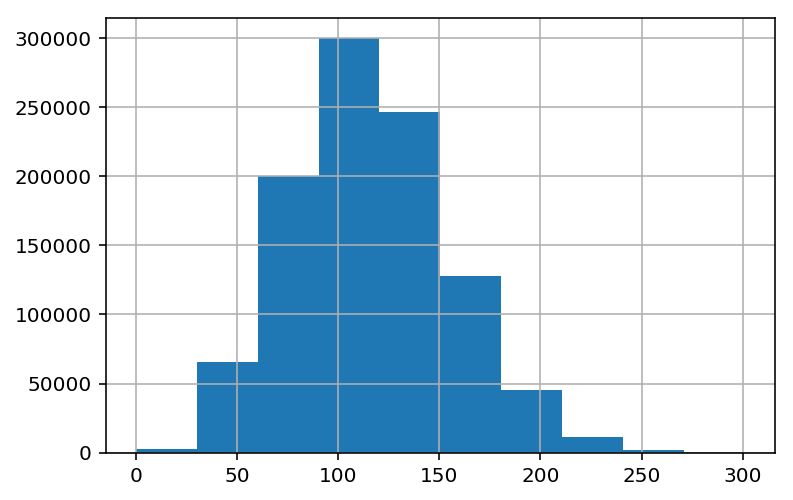

In [376]:
df['salary'].hist()
plt.show()

In [377]:
print('Min: {}\nMax: {}'.format(df['salary'].min(), df['salary'].max()))

Min: 0
Max: 301


In [378]:
group_one = df['salary'].max()/4 # max / 4
group_two = 2 * (df['salary'].max()/4) # 2 * (max / 4)
group_three = 3 * (df['salary'].max()/4) # 3 * (max / 4)
group_four = df['salary'].max() # max

print('One:   {}\nTwo:   {}\nThree: {}\nFour:  {}'.format(group_one, group_two, group_three, group_four))

One:   75.25
Two:   150.5
Three: 225.75
Four:  301


In [379]:
labels=[1,2,3,4,5,6,7,8,9,10,11,12]

In [380]:
# breaking up the salaries into the 4 groups listed above
salary_groups = pd.cut(x=df['salary'], 
                       bins=4,
                       labels=[1,2,3,4],
                       retbins=False)

In [381]:
# Combined the new categorical salary column with the data frame
df = df.join(salary_groups, how='left', rsuffix='_groups')

In [382]:
df.shape

(1000000, 102)

In [383]:
df.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,companyId_COMP0,...,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,salary_groups
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,0,...,0,0,0,0,0,1,0,0,0,2
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,0,...,1,0,0,0,0,0,0,0,1,2
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,0,...,0,1,0,0,0,1,0,0,0,2
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,0,...,0,0,1,0,0,0,0,0,0,2
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,0,...,0,1,0,0,1,0,0,0,0,3


In [384]:
# Baseline accuracy of 0.66 for the majority class 2
df['salary_groups'].value_counts().sort_index(ascending=True)[2]/len(df)

0.665052

In [385]:
df['salary_groups'].value_counts().sort_index(ascending=True)

1    149306
2    665052
3    180438
4      5204
Name: salary_groups, dtype: int64

## Initial Random Forest Results with Class Imbalance

In [386]:
integer_columns = df.select_dtypes(include='int64').columns

X = df[integer_columns].drop('salary', axis=1)
y = df['salary_groups'] 

In [387]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)  

In [388]:
pd.Series(y_train).value_counts()

2    465829
3    125959
1    104551
4      3661
Name: salary_groups, dtype: int64

In [389]:
rf = RandomForestClassifier(random_state=42)
rf = rf.fit(X_train, y_train)

In [390]:
print('Accuracy: {0:.3f} +/- {1:.3f}'.format(cross_val_score(rf, X=X_test, y=y_test, cv=10, scoring='accuracy').mean(),
                           cross_val_score(rf, X=X_test, y=y_test, cv=10, scoring='accuracy').std()))

Accuracy: 0.775 +/- 0.002


In [391]:
# Baseline accuracy of the majority class 2

In [392]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.76      0.72      0.74     44755
          2       0.81      0.88      0.84    199223
          3       0.62      0.46      0.53     54479
          4       0.28      0.05      0.08      1543

avg / total       0.76      0.77      0.77    300000



In [393]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 32191,  12564,      0,      0],
       [ 10189, 175003,  14020,     11],
       [     0,  29180,  25110,    189],
       [     0,     54,   1413,     76]])

## Random Forest Results with OversSampling Minority Classes

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

ros = RandomOverSampler(ratio='auto', random_state=42)
X_train, y_train = ros.fit_sample(X_train, y_train)

In [395]:
pd.Series(y_train).value_counts()

4    465829
3    465829
2    465829
1    465829
dtype: int64

In [396]:
rf = RandomForestClassifier(random_state=42)
rf = rf.fit(X_train, y_train)

In [397]:
print('Accuracy: {0:.3f} +/- {1:.3f}'.format(cross_val_score(rf, X=X_test, y=y_test, cv=10, scoring='accuracy').mean(),
                           cross_val_score(rf, X=X_test, y=y_test, cv=10, scoring='accuracy').std()))

Accuracy: 0.775 +/- 0.002


In [398]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.70      0.78      0.74     44755
          2       0.83      0.81      0.82    199223
          3       0.57      0.58      0.57     54479
          4       0.24      0.09      0.13      1543

avg / total       0.76      0.76      0.76    300000



In [399]:
cm_os = confusion_matrix(y_test, y_pred)
cm_os

array([[ 34776,   9979,      0,      0],
       [ 15071, 161819,  22306,     27],
       [     1,  22577,  31492,    409],
       [     0,     25,   1384,    134]])

## Random Forest Results with UnderSampling Majority Classes

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rus = RandomUnderSampler(ratio='auto', random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

In [401]:
pd.Series(y_train).value_counts()

4    3661
3    3661
2    3661
1    3661
dtype: int64

In [402]:
rf = RandomForestClassifier(random_state=42)
rf = rf.fit(X_train, y_train)

In [403]:
print('Accuracy: {0:.3f} +/- {1:.3f}'.format(cross_val_score(rf, X=X_test, y=y_test, cv=10, scoring='accuracy').mean(),
                           cross_val_score(rf, X=X_test, y=y_test, cv=10, scoring='accuracy').std()))

Accuracy: 0.775 +/- 0.002


In [404]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.55      0.89      0.68     44755
          2       0.88      0.62      0.72    199223
          3       0.43      0.59      0.50     54479
          4       0.10      0.86      0.18      1543

avg / total       0.74      0.65      0.67    300000



In [405]:
cm_us = confusion_matrix(y_test, y_pred)
cm_us

array([[ 39932,   4809,     14,      0],
       [ 32455, 122668,  41770,   2330],
       [    27,  12518,  32179,   9755],
       [     0,      5,    206,   1332]])

In [406]:
pd.concat([pd.Series(X.columns),pd.Series(rf.feature_importances_)], axis=1).sort_values(by=1,ascending=False)[:10]

,0,1
0,yearsExperience,0.162653
1,milesFromMetropolis,0.155350
68,jobType_JANITOR,0.062383
85,major_NONE,0.049682
65,jobType_CEO,0.047436
69,jobType_JUNIOR,0.028811
88,industry_EDUCATION,0.019037
66,jobType_CFO,0.018435
91,industry_OIL,0.018162
67,jobType_CTO,0.017408


In [407]:
for col in df[df.select_dtypes('object').columns.drop(['jobId','companyId'])]:
    print(col)
    print('-'*20)
    print(df[col].value_counts())
    print()

jobType
--------------------
SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

degree
--------------------
HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

major
--------------------
NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

industry
--------------------
WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

